In [134]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from umap import UMAP
import plotly.express as px

In [135]:
male_players = pd.read_csv('data/male_players.csv')
male_players

C:\Users\harry\AppData\Local\Temp\ipykernel_19912\2510204913.py:1: DtypeWarning:

Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.



,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,/player/231747/kylian-mbappe/240002,24.0,2.0,2023-09-22,K. Mbappé,Kylian Mbappé Lottin,"ST, LW",91,94,...,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3
1,239085,/player/239085/erling-haaland/240002,24.0,2.0,2023-09-22,E. Haaland,Erling Braut Haaland,ST,91,94,...,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,/player/192985/kevin-de-bruyne/240002,24.0,2.0,2023-09-22,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,...,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
3,158023,/player/158023/lionel-messi/240002,24.0,2.0,2023-09-22,L. Messi,Lionel Andrés Messi Cuccittini,"CF, CAM",90,90,...,63+3,63+3,63+3,64+3,59+3,49+3,49+3,49+3,59+3,19+3
4,165153,/player/165153/karim-benzema/240002,24.0,2.0,2023-09-22,K. Benzema,Karim Benzema,"CF, ST",90,90,...,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180016,220806,https://sofifa.com/player/220806/ellis-redman/...,15.0,2.0,2014-09-18,E. Redman,Ellis Redman,CB,41,61,...,38,38,38,37,40,41,41,41,40,10
180017,225509,https://sofifa.com/player/225509/aaron-collins...,15.0,2.0,2014-09-18,A. Collins,Aaron Graham John Collins,ST,41,50,...,30,30,30,31,32,31,31,31,32,14
180018,217591,https://sofifa.com/player/217591/piotr-zemlo/1...,15.0,2.0,2014-09-18,P. Żemło,Piotr Żemło,"LM, LB",40,50,...,46,46,46,48,51-1,53-3,53-3,53-3,51-1,12
180019,222947,https://sofifa.com/player/222947/tom-davies/15...,15.0,2.0,2014-09-18,T. Davies,Thomas Christopher Davies,CB,40,49,...,36,36,36,37,39,40,40,40,39,13


### EDA

In [136]:
# drop the columns that are unrelevant to our anaylsis
male_players = male_players.drop(['player_url','short_name', 'long_name',
                                  'potential','value_eur','wage_eur','age',
                                  'dob','club_team_id','club_name','league_id',
                                  'league_name','league_level','club_position','club_jersey_number',
                                  'club_loaned_from','club_joined_date','club_contract_valid_until_year',
                                  'nationality_id','nationality_name', 'nation_team_id','nation_position',
                                  'nation_jersey_number','international_reputation','body_type','real_face',
                                  'release_clause_eur','player_tags','player_traits', 'fifa_update', 'goalkeeping_speed',
                                    'shooting', 'passing', 'physic', 'defending', 'dribbling', 'pace', 'mentality_composure'], axis = 1)
male_players

,player_id,fifa_version,update_as_of,player_positions,overall,height_cm,weight_kg,preferred_foot,weak_foot,skill_moves,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,24.0,2023-09-22,"ST, LW",91,182,75,Right,4,5,...,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3
1,239085,24.0,2023-09-22,ST,91,195,94,Left,3,3,...,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,24.0,2023-09-22,"CM, CAM",91,181,75,Right,5,4,...,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
3,158023,24.0,2023-09-22,"CF, CAM",90,169,67,Left,4,4,...,63+3,63+3,63+3,64+3,59+3,49+3,49+3,49+3,59+3,19+3
4,165153,24.0,2023-09-22,"CF, ST",90,185,81,Right,4,4,...,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180016,220806,15.0,2014-09-18,CB,41,187,81,Right,2,2,...,38,38,38,37,40,41,41,41,40,10
180017,225509,15.0,2014-09-18,ST,41,178,57,Right,3,3,...,30,30,30,31,32,31,31,31,32,14
180018,217591,15.0,2014-09-18,"LM, LB",40,190,76,Left,3,2,...,46,46,46,48,51-1,53-3,53-3,53-3,51-1,12
180019,222947,15.0,2014-09-18,CB,40,180,70,Right,2,2,...,36,36,36,37,39,40,40,40,39,13


In [137]:
pd.set_option('display.max_rows', 10)
male_players_24 = male_players[male_players['fifa_version'] == 24.0]
male_players_24 

,player_id,fifa_version,update_as_of,player_positions,overall,height_cm,weight_kg,preferred_foot,weak_foot,skill_moves,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,231747,24.0,2023-09-22,"ST, LW",91,182,75,Right,4,5,...,63+3,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3
1,239085,24.0,2023-09-22,ST,91,195,94,Left,3,3,...,63+3,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3
2,192985,24.0,2023-09-22,"CM, CAM",91,181,75,Right,5,4,...,80+3,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3
3,158023,24.0,2023-09-22,"CF, CAM",90,169,67,Left,4,4,...,63+3,63+3,63+3,64+3,59+3,49+3,49+3,49+3,59+3,19+3
4,165153,24.0,2023-09-22,"CF, ST",90,185,81,Right,4,4,...,64+3,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18345,273759,24.0,2023-09-22,CB,47,176,76,Left,3,2,...,39+2,39+2,39+2,41+2,43+2,47+2,47+2,47+2,43+2,13+2
18346,269013,24.0,2023-09-22,CB,47,183,74,Right,3,2,...,43+2,43+2,43+2,44+2,46+2,47+2,47+2,47+2,46+2,13+2
18347,272748,24.0,2023-09-22,ST,47,184,65,Right,2,2,...,31+2,31+2,31+2,35+2,33+2,27+2,27+2,27+2,33+2,13+2
18348,269534,24.0,2023-09-22,CM,47,178,74,Right,3,2,...,45+2,45+2,45+2,45+2,45+2,44+2,44+2,44+2,45+2,14+2


In [138]:
# check if any na values still remain
missing = male_players.isna().sum()
missing.sort_values(ascending= False)

player_id                0
st                       0
rw                       0
rf                       0
cf                       0
                        ..
movement_agility         0
movement_sprint_speed    0
movement_acceleration    0
skill_ball_control       0
gk                       0
Length: 71, dtype: int64

In [139]:
# define broad categories
defender_positions = {'CB', 'LB', 'RB', 'LWB', 'RWB', 'DB'}
midfielder_positions = {'CM', 'CAM', 'CDM', 'LM', 'RM'}
forward_positions = {'CF', 'ST', 'LW', 'RW'}
goalkeeper_position = {'GK'}

In [140]:
def generalize_position(position):
    positions = position.replace(' ', '').split(',')
    for pos in positions:
        if pos in goalkeeper_position:
            return 'GK'
        elif pos in defender_positions:
            return 'D'
        elif pos in midfielder_positions:
            return 'M'
        elif pos in forward_positions:
            return 'F'
    return 'Unknown'

In [141]:
# Apply function to player positions
male_players_24['broad_position'] = male_players_24['player_positions'].apply(generalize_position)

male_players_24['broad_position'].unique()

C:\Users\harry\AppData\Local\Temp\ipykernel_19912\1509442758.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array(['F', 'M', 'GK', 'D'], dtype=object)

In [142]:
male_players_24.dtypes[::-1][:10]

broad_position    object
gk                object
rb                object
rcb               object
cb                object
lcb               object
lb                object
rwb               object
rdm               object
cdm               object
dtype: object

In [143]:
# remove + or - symbols in player's stats
male_players_24 = male_players_24.copy()

def remove_symbols_and_convert_int(value):
    value = str(value)
    if pd.isna(value):
        return np.nan
    # split the string at '+' or '-' and convert to integer
    for char in ['+', '-']:
        if char in value:
            return int(value.split(char)[0])
    # if neither '+' nor '-' is in the value, just convert it to integer
    return int(value)

columns_to_process = ['ls', 'st', 'rs',
       'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm',
       'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb',
       'rcb', 'rb', 'gk']

for column in columns_to_process:
    male_players_24.loc[:, column] = male_players_24[column].apply(remove_symbols_and_convert_int)

male_players_24

,player_id,fifa_version,update_as_of,player_positions,overall,height_cm,weight_kg,preferred_foot,weak_foot,skill_moves,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,broad_position
0,231747,24.0,2023-09-22,"ST, LW",91,182,75,Right,4,5,...,63,63,68,63,54,54,54,63,18,F
1,239085,24.0,2023-09-22,ST,91,195,94,Left,3,3,...,63,63,62,60,62,62,62,60,19,F
2,192985,24.0,2023-09-22,"CM, CAM",91,181,75,Right,5,4,...,80,80,79,75,70,70,70,75,21,M
3,158023,24.0,2023-09-22,"CF, CAM",90,169,67,Left,4,4,...,63,63,64,59,49,49,49,59,19,F
4,165153,24.0,2023-09-22,"CF, ST",90,185,81,Right,4,4,...,64,64,64,60,55,55,55,60,18,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18345,273759,24.0,2023-09-22,CB,47,176,76,Left,3,2,...,39,39,41,43,47,47,47,43,13,D
18346,269013,24.0,2023-09-22,CB,47,183,74,Right,3,2,...,43,43,44,46,47,47,47,46,13,D
18347,272748,24.0,2023-09-22,ST,47,184,65,Right,2,2,...,31,31,35,33,27,27,27,33,13,F
18348,269534,24.0,2023-09-22,CM,47,178,74,Right,3,2,...,45,45,45,45,44,44,44,45,14,M


In [144]:
# number of players in each position's
male_players_24.groupby('broad_position')['player_id'].count()

broad_position
D     6174
F     3458
GK    2045
M     6673
Name: player_id, dtype: int64

In [145]:
attributes=['lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram']

# Melting the DataFrame to have attribute names in a single column and their values in another
melted_df = male_players_24.melt(id_vars=['broad_position'], value_vars=attributes, var_name='Attribute', value_name='Value')
melted_df

,broad_position,Attribute,Value
0,F,lw,91
1,F,lw,82
2,M,lw,87
3,F,lw,90
4,F,lw,86
...,...,...,...
146795,D,ram,28
146796,D,ram,33
146797,F,ram,45
146798,M,ram,47


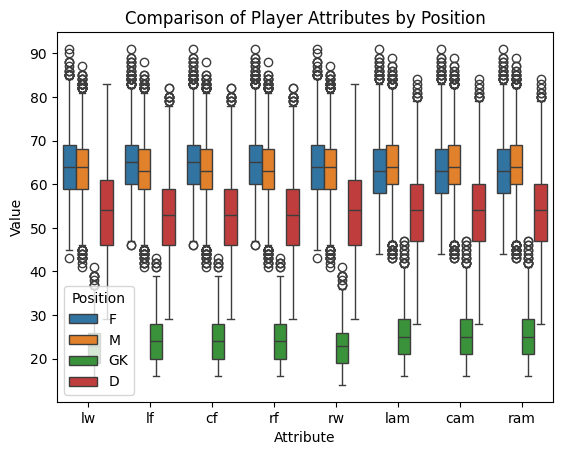

In [146]:
# boxplot of each position's attributes
sns.boxplot(data=melted_df, x='Attribute', y='Value', hue='broad_position')
plt.title('Comparison of Player Attributes by Position')
plt.xlabel('Attribute')
plt.ylabel('Value')
plt.legend(title='Position')
plt.show()

In [147]:
# correlation matrix
corr_matrix = male_players_24[attributes].corr()
corr_matrix

,lw,lf,cf,rf,rw,lam,cam,ram
lw,1.000000,0.994407,0.994407,0.994407,1.000000,0.992693,0.992693,0.992693
lf,0.994407,1.000000,1.000000,1.000000,0.994407,0.994642,0.994642,0.994642
cf,0.994407,1.000000,1.000000,1.000000,0.994407,0.994642,0.994642,0.994642
rf,0.994407,1.000000,1.000000,1.000000,0.994407,0.994642,0.994642,0.994642
rw,1.000000,0.994407,0.994407,0.994407,1.000000,0.992693,0.992693,0.992693
lam,0.992693,0.994642,0.994642,0.994642,0.992693,1.000000,1.000000,1.000000
cam,0.992693,0.994642,0.994642,0.994642,0.992693,1.000000,1.000000,1.000000
ram,0.992693,0.994642,0.994642,0.994642,0.992693,1.000000,1.000000,1.000000


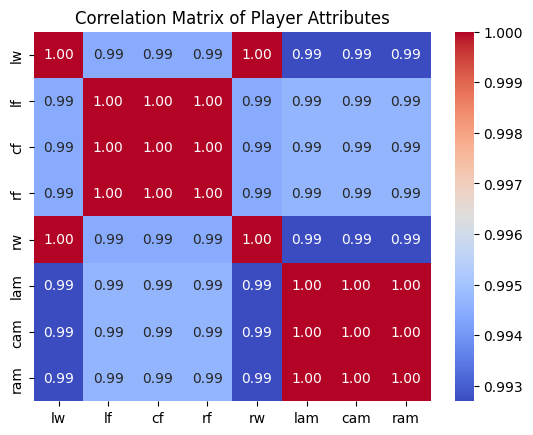

In [148]:
# heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm') # square=True, linewidths=.5, cbar_kws={"shrink": .5}
plt.title('Correlation Matrix of Player Attributes')
plt.show()

---
## Harry's part

### Dimensionality Reduction

In [149]:
#here are the relevant features that we will use in our clustering
keeping_features = [
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision',
        'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'ls', 'st', 'rs',
       'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm',
       'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb',
       'rcb', 'rb', 'gk']

X = male_players_24[keeping_features]

In [150]:
min_value = X.min().min()
max_value = X.max().max()

print("Minimum value in X:", min_value)
print("Maximum value in X:", max_value)

Minimum value in X: 2
Maximum value in X: 97


In [151]:
# we need to standardize the values since the range is not 0-100
X_scaled = StandardScaler().fit_transform(X)

### PCA

In [152]:
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled)

In [153]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained by all selected components:", sum(pca.explained_variance_ratio_))

Explained variance ratio: [0.68999728 0.14181603 0.05190996 0.03657091]
Total variance explained by all selected components: 0.9202941854059092


The explained variance ratio is a metric that tells you how much of the total variance in your dataset is captured by each principal component generated by PCA (Principal Component Analysis). Specifically, it indicates the proportion of the dataset's variance that lies along each principal component axis.

The first principal component captures approximately 67.85% of the variance in the dataset, second principal component, 0.16%, and so on. This means that a significant portion of the information (or variability) in your dataset can be represented along this first principal component dimension.

Text(0.5, 1.0, 'PCA Projection - First Two Principal Components')

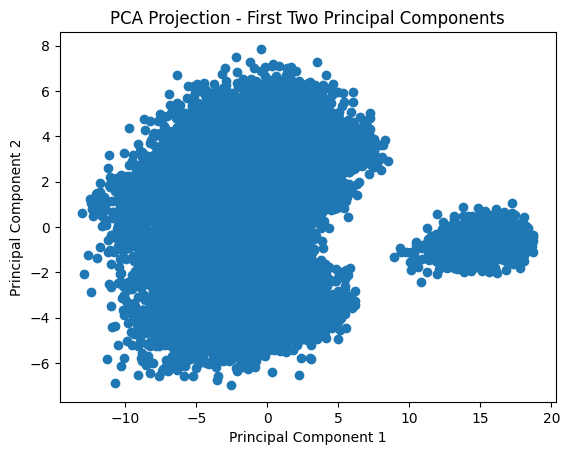

In [154]:
# scatter plot the pc1 and pc2
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection - First Two Principal Components')

The above scatter plot is not enough to do the dimensionality reduction for 4 ground truth positions.  We can only observe 2 clusters and the small cluster will be goal keeper and the big cluster most likely contain the other 3 positions.

Now do another dimensionality reduction approach.

### UMAP

In [155]:
umap = UMAP(n_neighbors=10, min_dist=0.7, n_components=2) # maybe use grid search to find appropriate parameters!

# Fit UMAP and transform your data
X_umap = umap.fit_transform(X_scaled)

Text(0, 0.5, 'UMAP Component 2')

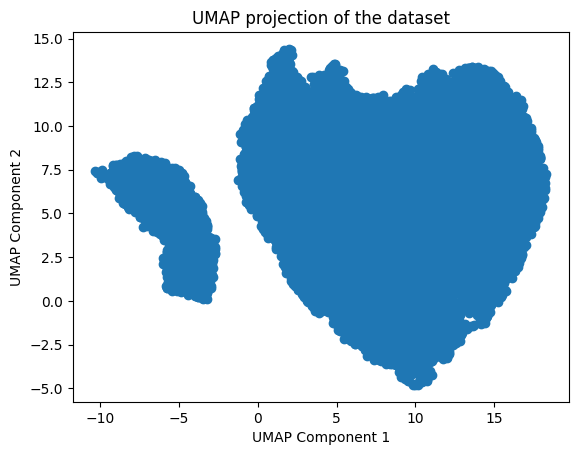

In [156]:
plt.scatter(X_umap[:, 0], X_umap[:, 1])
plt.title('UMAP projection of the dataset')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

Since trying multiple tries doesn't give the exact 4 clusters, try the 3d versions with n_components=3

In [157]:
umap_3d = UMAP(n_neighbors=10, min_dist=0.5, n_components=3) # maybe use grid search to find appropriate parameters!

# Fit UMAP and transform your data
X_umap_3d = umap_3d.fit_transform(X_scaled)

In [158]:
fig = px.scatter_3d(
    x=X_umap_3d[:, 0],
    y=X_umap_3d[:, 1],
    z=X_umap_3d[:, 2],
    title='3D UMAP projection of the dataset'
)

fig.update_layout(
    scene=dict(
        xaxis_title='UMAP Component 1',
        yaxis_title='UMAP Component 2',
        zaxis_title='UMAP Component 3'
    )
)

### K means


In [159]:
# compare the ground truth for metrics
true_labels = male_players_24['broad_position']

In [160]:
kmeans = KMeans(n_clusters=4)
cluster_labels_k = kmeans.fit_predict(X_scaled)
cluster_labels_k

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([3, 3, 3, ..., 0, 1, 1])

Text(0, 0.5, 'Component 2')

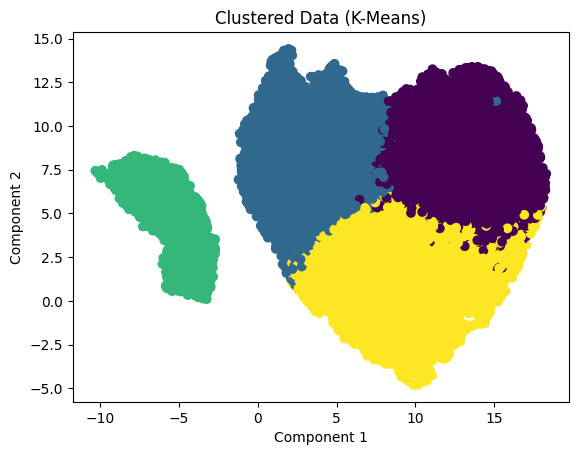

In [161]:
# scatter plot of the clustered ones
# use the umap that has not been finalized
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels_k)
plt.title('Clustered Data (K-Means)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

In [162]:
# calculate metrics 
silhouette_avg_k = silhouette_score(X_scaled, cluster_labels_k)
print(f'Silhouette Score K means: {silhouette_avg_k:.2f}')
ari_k = adjusted_rand_score(true_labels, cluster_labels_k)
print(f'Adjusted Rand Index: {ari_k:.2f}')

Silhouette Score K means: 0.33
Adjusted Rand Index: 0.36


### Gaussian Mixture Model

In [163]:
gmm = GaussianMixture(n_components=4)
cluster_labels_gmm = gmm.fit_predict(X_scaled)
cluster_labels_gmm

array([2, 2, 2, ..., 2, 2, 3], dtype=int64)

Text(0, 0.5, 'Component 2')

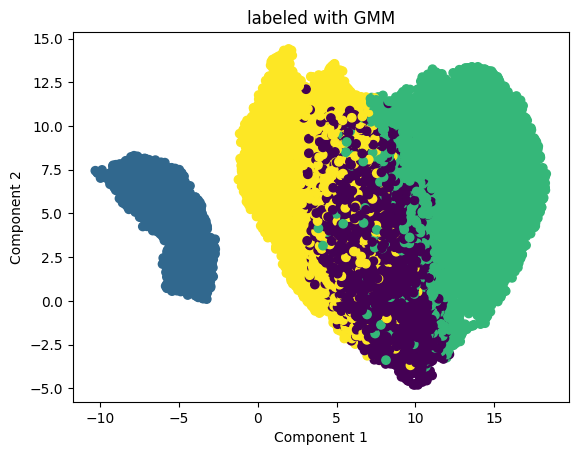

In [164]:
# scatter plot of the clustered ones using GM
# use the umap that has not been finalized

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels_gmm)
plt.title('labeled with GMM')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

In [165]:
# calculate metrics 
silhouette_avg_gmm = silhouette_score(X_scaled, cluster_labels_gmm)
print(f'Silhouette Score (GMM): {silhouette_avg_gmm:.2f}')

ari_gmm = adjusted_rand_score(true_labels, cluster_labels_gmm)
print(f'Adjusted Rand Index (GMM): {ari_gmm:.2f}')

Silhouette Score (GMM): 0.24
Adjusted Rand Index (GMM): 0.42


### End of Harry's section
---

## Start of Clustering

In [166]:
#here are the relevant features that we will use in our clustering
features = [
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision',
        'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'ls', 'st', 'rs',
       'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm',
       'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb',
       'rcb', 'rb', 'gk']

X = male_players_24[features]

X = StandardScaler().fit_transform(X)

In [167]:
#create 2 Pipelines with Scaling, PCA, and our clustering algorithms

pipe_kmeans = Pipeline([
    
    ('PCA', PCA()),
    ('kmeans', KMeans(random_state=42))
])

pipe_gmm = Pipeline([
    ("scaler", StandardScaler()),
    ('PCA', PCA(n_components=2)),
    ('gmm', GaussianMixture(random_state=42))
])

In [168]:
#make 2 GridSearchCV objects for each pipeline

param_grid_kmeans = {
    "PCA__n_components": [2, 3, 4],
    "kmeans__n_clusters": [4, 6, 8, 11]
}

param_grid_gmm = {
    "PCA__n_components": [2, 3, 4],
    "gmm__n_components": [4, 6, 8, 11],
    "gmm_covariance_type": ["full", "tied", "diag", "spherical"]
}
GSCV_kmeans = GridSearchCV(pipe_kmeans, param_grid_kmeans, n_jobs=-1)
GSCV_gmm = GridSearchCV(pipe_gmm, param_grid_gmm, n_jobs=-1)

In [169]:
fitted_kmeans = GSCV_kmeans.fit(X)
print("Best hyperparameters: \n" ,fitted_kmeans.best_params_, 
      "Best score: \n" ,fitted_kmeans.best_score_)

KeyboardInterrupt: 

In [ ]:
param_grid_test = {
    "PCA__n_components": [2],
    "kmeans__n_clusters": [4]
}

GSCV_test = GridSearchCV(pipe_kmeans, param_grid_test, n_jobs=-1, scoring='adjusted_rand_score',

               verbose=3)

In [ ]:
fit_test = GSCV_test.fit(X)
print(GSCV_test.best_score_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Python311\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning:

One or more of the test scores are non-finite: [nan]



nan


c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
fitted_gmm = GSCV_gmm.fit(X)
fitted_gmm.best_params_

ValueError: Invalid parameter 'gmm_covariance_type' for estimator Pipeline(steps=[('scaler', StandardScaler()), ('PCA', PCA(n_components=2)),
                ('gmm', GaussianMixture(random_state=42))]). Valid parameters are: ['memory', 'steps', 'verbose'].

c:\Users\akhil\anaconda3\envs\COGS118B_WI24\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.46496272548703627


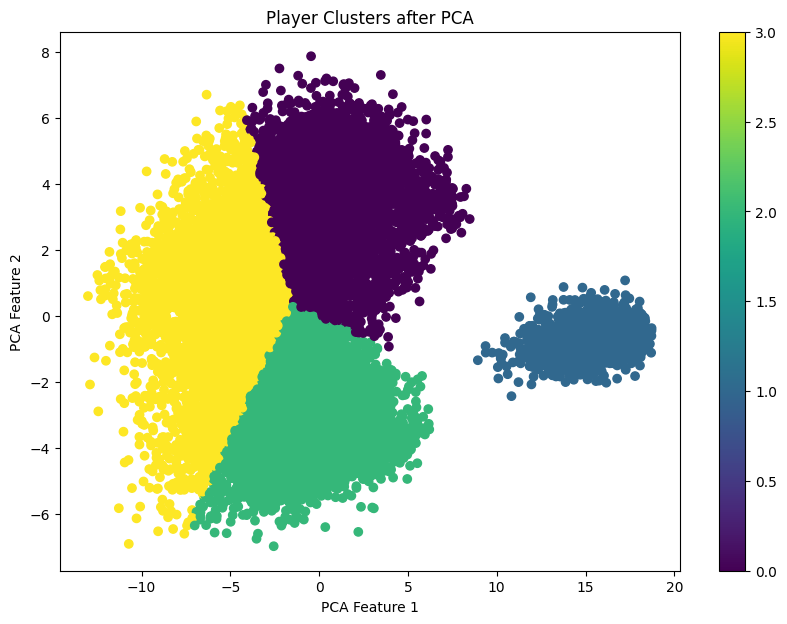

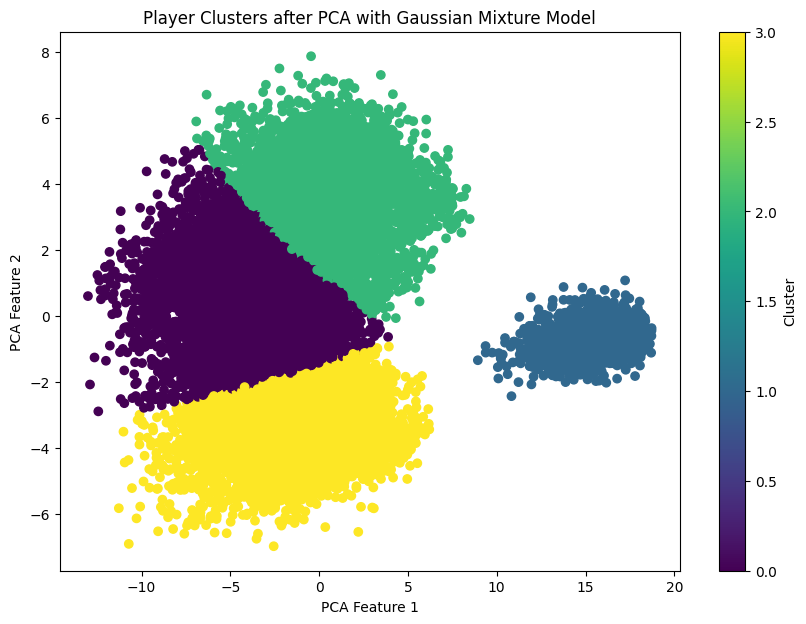

In [ ]:


# Adding cluster labels to the original dataframe
male_players_24['kmeans_cluster'] = kmeans.labels_

# Evaluating the clustering
silhouette_avg = silhouette_score(X_pca, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')

# Plotting the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('Player Clusters after PCA')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar()
plt.show()

# Initialize the Gaussian Mixture Model
gmm = GaussianMixture(n_components=4, random_state=42)

# Fit the GMM model to the PCA-transformed data
gmm.fit(X_pca)

# Predict the cluster labels
gmm_labels = gmm.predict(X_pca)

# Adding cluster labels to the original dataframe
male_players_24['gmm_cluster'] = gmm_labels

# Plotting the GMM clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis')
plt.title('Player Clusters after PCA with Gaussian Mixture Model')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import rand_score

ari = adjusted_rand_score(male_players_24['broad_position'], gmm_labels)
ri = rand_score(male_players_24['broad_position'], gmm_labels)
print(f'Adjusted Rand Index (ARI): {ari}')
print(f'Rand Index (RI): {ri}')

Adjusted Rand Index (ARI): 0.4018437134934892
Rand Index (RI): 0.7543975742502729


In [ ]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import rand_score

ari = adjusted_rand_score(male_players_24['broad_position'], kmeans.labels_)
ri = rand_score(male_players_24['broad_position'], kmeans.labels_)
print(f'Adjusted Rand Index (ARI): {ari}')
print(f'Rand Index (RI): {ri}')

Adjusted Rand Index (ARI): 0.3608917237604377
Rand Index (RI): 0.7391925047552874
